### glob
* glob.glob()
    * 디렉토리, 파일

In [1]:
import glob
from pathlib import Path


train_path = './paddy-disease-classification/train_images/'
test_path = './paddy-disease-classification/test_images/'

print(glob.glob(train_path + '/*/'))
print()

for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f'{len(files)} \t {Path(filepath).name}')

files = glob.glob(test_path + '*')
print(f'{len(files)} \t {Path(test_path).name}')

['./paddy-disease-classification/train_images\\bacterial_leaf_blight\\', './paddy-disease-classification/train_images\\bacterial_leaf_streak\\', './paddy-disease-classification/train_images\\bacterial_panicle_blight\\', './paddy-disease-classification/train_images\\blast\\', './paddy-disease-classification/train_images\\brown_spot\\', './paddy-disease-classification/train_images\\dead_heart\\', './paddy-disease-classification/train_images\\downy_mildew\\', './paddy-disease-classification/train_images\\hispa\\', './paddy-disease-classification/train_images\\normal\\', './paddy-disease-classification/train_images\\tungro\\']

479 	 bacterial_leaf_blight
380 	 bacterial_leaf_streak
337 	 bacterial_panicle_blight
1738 	 blast
965 	 brown_spot
1442 	 dead_heart
620 	 downy_mildew
1594 	 hispa
1764 	 normal
1088 	 tungro
3469 	 test_images


In [2]:
import numpy as np
import pandas as pd
import os

from os import listdir
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
from psutil import virtual_memory


SEED = 123
EPOCHS = 50
INIT_LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

NUM_CLASSES = len(glob.glob(train_path + '/*/'))
print(NUM_CLASSES)

10


### Dropout
* 뉴런 활성화 여부
* 과적합 방지 목적

### BatchNormalization
* 층으로 들어가는 입력값이 한쪽으로 쏠리거나 너무 퍼지거나 너무 좁이지지 않게 해주는 기법
* 각 층의 입력값의 평균과 표준편차 다시 맞춤

### optimizer
* learning_rate
* decay - learning_rate 감소 정도

channels_last
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85

c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


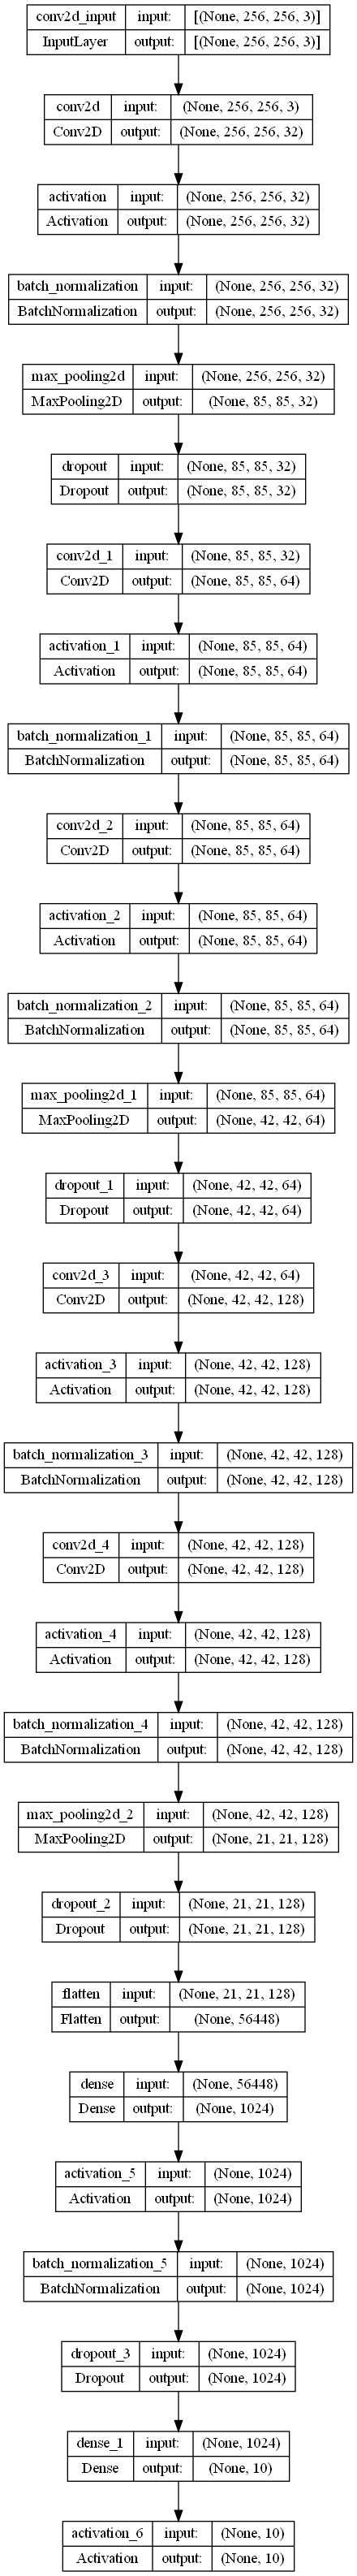

In [3]:
def get_model():
    model = Sequential()
    input_shape = (HEIGHT, WIDTH, DEPTH)
    channel_dim = -1
    print(K.image_data_format())
    if K.image_data_format() == 'channels_first':
        input_shape = (DEPTH, HEIGHT, WIDTH)
        channel_dim = 1
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = get_model()

model.summary()
plot_model(model, './model.png', show_shapes=True)

### ImageDataGenerator
* rescale: 이미지 처리 마지막에 주어진 값 곱해 크기 조정.
* validation_split: train, valid 이미지 자동으로 나누기. subset 통해 부름.
* rotation_rage: 사진 회전시킬 각도 (0~180)
* shear_range: shearing transformation (0.3 -> 30%). 이미지 찌그러뜨림.
* zoom_range: 사진 확대 또는 축소 범위 (0.3 -> 30%)
* horizontal_flip: 랜덤하게 이미지 수평으로 뒤집기
* width_shift_range: 사진을 수평으로 평행이동 시킬 범위 (0 이하 전체의 비율, 0이상 픽셀 단위)
* height_shift_range: 무작위로 이미지를 좌우로 뒤집기. 수평 대칭을 가정할 수 있을 때 사용. (풍경/인물 사진)
* vertical_flip: 무작위로 이미지를 상하로 뒤집기. 수직 대칭을 가정할 수 있을 때 사용.

* featurewise_center: 데이터셋에 대해 특성별로 인풋의 평균이 0이 되도록
* samplewise_center: 각 샘플의 평균이 0이 되도록
* featurewise_std_normalization: 인풋을 각 특성 내에서 데이터셋의 표준편차로 나눔
* samplewise_std_normalization: 각 인풋을 표준편차로 나상상
* zca_whitening: 영위상 성분분석 백색화
* channel_shift_range: 무작위 채널 이동 범위
* fill_mode: 회전 축소 등으로 이미지에 여백이 생겼을때 채우는 방법
    * nearest: 가장 가까운 픽셀 찾아 늘림 (default)
    * constant: 다음에 있는 cval값으로 채움
    * reflect: 원본 이미지 대칭
    * wrap: 원본 이미지 이어 붙임

In [4]:
image_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    channel_shift_range=0.,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2
)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(WIDTH, HEIGHT),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = image_datagen.flow_from_directory(
    directory=train_path,
    subset='validation',
    target_size=(WIDTH, HEIGHT),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(WIDTH, HEIGHT),
    color_mode='rgb',
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED
)

print()
print(train_generator.class_indices)
print()
print(test_generator.samples)

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 3469 images belonging to 1 classes.

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}

3469


In [5]:
%%time

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS
)

Epoch 1/2
260/260 [==============================] - 322s 1s/step - loss: 2.3800 - accuracy: 0.3200 - val_loss: 5.9150 - val_accuracy: 0.1533
Epoch 2/2
260/260 [==============================] - 111s 426ms/step - loss: 1.6559 - accuracy: 0.4737 - val_loss: 2.0456 - val_accuracy: 0.3789
CPU times: total: 4min 14s
Wall time: 7min 21s


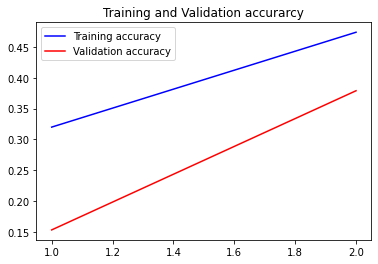

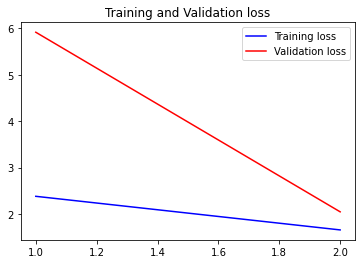

CPU times: total: 156 ms
Wall time: 157 ms


In [6]:
%%time

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [7]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

C:\Users\posky\AppData\Local\Temp\ipykernel_65060\3269744968.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(


3469/3469 [==============================] - 14s 4ms/step


In [8]:
loss, acc = model.evaluate_generator(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)
print(acc, loss)

  15/3469 [..............................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 0.0000e+00 

C:\Users\posky\AppData\Local\Temp\ipykernel_65060\1082029536.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(


3469/3469 [==============================] - 12s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [9]:
pd.Series(train_generator.classes).value_counts()

8    1412
3    1391
7    1276
5    1154
9     871
4     772
6     496
0     384
1     304
2     270
dtype: int64

In [10]:
pd.Series(test_generator.classes).value_counts()

0    3469
dtype: int64

In [23]:
class_names = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda x: x[1])]

df = pd.DataFrame({
    'image_id': list(map(os.path.basename, test_generator.filenames))
})
df[class_names] = pred
df.to_csv('cnn_predictions.csv', index=False)

In [18]:
pred.shape

(3469, 10)

In [22]:
predicted_class_indices = np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      928
hispa                       546
blast                       523
dead_heart                  519
tungro                      291
brown_spot                  189
bacterial_leaf_blight       146
downy_mildew                131
bacterial_leaf_streak       116
bacterial_panicle_blight     80
dtype: int64

In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({
    "image_id": filenames,
    "label": predictions
})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("cnn_submission.csv", index=False)
results.head()